# SCM demo 共変量入り

[参考](https://zenn.dev/falconnnmmm/articles/ecf333ba18b2f7)

In [5]:
# 必要なライブラリ
import pandas as pd
import polars as pl
from scipy.optimize import minimize
import plotly.graph_objects as go # 可視化
from numpy.linalg import lstsq
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq

## データ読み込み

In [9]:
df = pd.read_stata("smoking.dta")[["state","year","cigsale","retprice"]]

# wide 形式にしておく
wide_cig = df.pivot(index="year", columns="state", values="cigsale").sort_index()
wide_prc = df.pivot(index="year", columns="state", values="retprice").sort_index()

treated = "California"
donors  = [s for s in wide_cig.columns if s != treated]

# pre_years  = list(range(1970, 1989))
# post_years = list(range(1989, 2001))
pre_years  = list(range(1970, 1981))
post_years = list(range(1982, 1988))


## OLS

In [10]:
# 説明変数行列： [cigsale_A …; retprice_A …] 列方向に連結
X_pre = np.hstack([
    wide_cig.loc[pre_years, donors].values,   # 19×J
    wide_prc.loc[pre_years, donors].values    # 19×J
])                      # → 19×(2J)
y_pre = wide_cig.loc[pre_years, treated].values

beta_ols, *_ = lstsq(X_pre, y_pre, rcond=None)

# 予測系列を全期間で生成
X_full = np.hstack([
    wide_cig.loc[:, donors].values,
    wide_prc.loc[:, donors].values
])
y_hat_ols = X_full @ beta_ols

## SCM

In [11]:
J = len(donors)
W = cp.Variable(J)

# (a) 販売量の残差
cig_res = wide_cig.loc[pre_years, treated].values - wide_cig.loc[pre_years, donors].values @ W
# (b) 価格の残差
prc_res = wide_prc.loc[pre_years, treated].values - wide_prc.loc[pre_years, donors].values @ W

objective   = cp.Minimize(cp.sum_squares(cig_res) + cp.sum_squares(prc_res))
constraints = [W >= 0, cp.sum(W) == 1]

prob = cp.Problem(objective, constraints)
prob.solve()

sc_weights = pd.Series(W.value, index=donors, name="SC weight")
y_hat_sc   = (wide_cig[donors] @ sc_weights).rename("Synthetic cigsale")


Utah             2.850645e-01
Connecticut      2.754572e-01
Nevada           2.328480e-01
Colorado         1.338699e-01
West Virginia    7.123385e-02
Delaware         1.526622e-03
New Hampshire    2.051378e-17
Indiana         -4.723073e-17
Idaho           -5.967034e-17
Montana         -6.453064e-17
Name: SC weight, dtype: float64


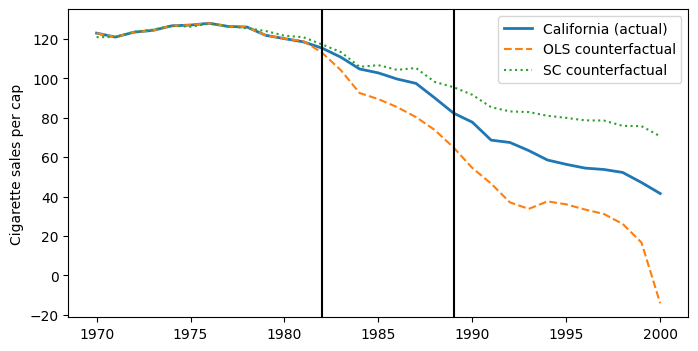

In [13]:
plt.style.use("default")

# ----- 重み ---------
print(sc_weights.sort_values(ascending=False).head(10))

# ----- シリーズ --------
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(wide_cig.index, wide_cig[treated], label="California (actual)", lw=2)
ax.plot(wide_cig.index, y_hat_ols,        label="OLS counterfactual", ls="--")
ax.plot(wide_cig.index, y_hat_sc,         label="SC counterfactual",  ls=":")
ax.axvline(1982, color="k")
ax.axvline(1989, color="k")
ax.set_ylabel("Cigarette sales per cap"); ax.legend()
plt.show()
